In [2]:
import os

import numpy as np
import scipy as sp
from scipy import misc, stats
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
#import plotly.plotly as py
import seaborn as sns
from pandas import DataFrame, Series
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

In [3]:
MAIN_TAG = 'explore'
DIRNAME_TAGS = 'Q:/mirflickr25k/mirflickr/meta/tags'
DIRNAME_IMAGES = 'Q:/mirflickr25k/mirflickr/'

COLOR = {'red': 0,
         'green': 1,
         'blue': 2}

In [4]:
from os import listdir
from matplotlib import image
import random
# load all images in a directory
np.random.RandomState(1)
random_indexes = np.random.choice(range(25000), 250)
loaded_images = list()
image_names = list()
for i in range(250):
	# load image
	randName = random_indexes[i]
	image_names.append(randName)
	filename = 'im' + str(randName) + '.jpg'
	img_data = image.imread('Q:/mirflickr25k/mirflickr/' + filename)
	# store loaded image
	loaded_images.append(img_data)
	print('> loaded %s %s' % (filename, img_data.shape))

> loaded im7478.jpg (333, 500, 3)
> loaded im11006.jpg (375, 500, 3)
> loaded im20309.jpg (500, 443, 3)
> loaded im19560.jpg (500, 333, 3)
> loaded im6066.jpg (500, 400, 3)
> loaded im24927.jpg (371, 500, 3)
> loaded im22829.jpg (500, 333, 3)
> loaded im24348.jpg (333, 500, 3)
> loaded im8541.jpg (348, 500, 3)
> loaded im18373.jpg (375, 500, 3)
> loaded im8191.jpg (439, 500, 3)
> loaded im1438.jpg (375, 500, 3)
> loaded im15997.jpg (125, 500, 3)
> loaded im14684.jpg (500, 346, 3)
> loaded im9842.jpg (375, 500, 3)
> loaded im22678.jpg (392, 500, 3)
> loaded im11170.jpg (375, 500, 3)
> loaded im10621.jpg (315, 500, 3)
> loaded im7168.jpg (333, 500, 3)
> loaded im20254.jpg (500, 500, 3)
> loaded im13848.jpg (333, 500, 3)
> loaded im14729.jpg (500, 333, 3)
> loaded im19807.jpg (500, 378, 3)
> loaded im9342.jpg (500, 499, 3)
> loaded im15409.jpg (335, 500, 3)
> loaded im653.jpg (339, 500, 3)
> loaded im15850.jpg (375, 500, 3)
> loaded im18621.jpg (375, 500, 3)
> loaded im1462.jpg (337, 500,

> loaded im4588.jpg (375, 500, 3)
> loaded im890.jpg (279, 500, 3)
> loaded im19880.jpg (500, 500, 3)
> loaded im21936.jpg (333, 500, 3)
> loaded im12688.jpg (375, 500, 3)
> loaded im10732.jpg (333, 500, 3)
> loaded im1095.jpg (500, 333, 3)
> loaded im10185.jpg (250, 500, 3)


In [5]:
len(image_names)

250

In [6]:
import codecs

Y = pd.Series()
for name in image_names:
    with codecs.open(os.path.join(DIRNAME_TAGS, 'tags%d.txt' % (name,)), "r", "utf_8_sig") as file:
        set_tags = set(tag.strip() for tag in file.readlines())
        #print('tags%d.txt' % (name,), '  ',set_tags)
        Y.at[name] = int(MAIN_TAG in set_tags)
Y = pd.DataFrame(Y, columns=['target'])

In [7]:
Y['target'].value_counts()

0    239
1      8
Name: target, dtype: int64

In [8]:
Y.head()

,target
7478,0
11006,0
20309,0
19560,0
6066,0


## Static data

In [9]:
data_static = DataFrame()
num = 0
d = []
for image_name in image_names:
    image = np.array(Image.open(os.path.join(DIRNAME_IMAGES, 'im%d.jpg' % (image_name))))
    data = []
    for name, num in COLOR.items():
        a = image[:, :, num].ravel()
        data.extend([np.mean(a), np.var(a), sp.stats.skew(a), sp.stats.kurtosis(a)])
    d.append([image_name, *data])
    

data_static = pd.DataFrame.from_records(d)
data_static = data_static.rename(columns={0: 'name'}).set_index('name')

In [10]:
data_static.head()

,1,2,3,4,5,6,7,8,9,10,11,12
name,,,,,,,,,,,,
7478,89.576613,4675.503482,0.615343,-0.582947,86.831141,4267.924466,0.900903,-0.127490,68.999141,4722.331249,1.156540,0.493431
11006,112.868336,1026.288985,-0.777766,1.372925,131.197728,921.423186,-0.648102,2.730897,115.564848,1438.315128,-0.581081,1.466601
20309,176.971088,3816.737331,-1.097455,-0.075130,170.425359,3963.634821,-0.975969,-0.195976,165.393603,3644.093452,-0.733318,-0.462390
19560,133.059682,3088.026450,0.028407,-0.484005,133.512775,3041.392972,-0.049931,-0.461843,121.570607,3396.521856,0.263090,-0.581437
6066,97.218415,5553.446210,0.666253,-0.819847,83.859260,3262.297402,0.436944,-0.875699,84.935945,2393.547242,0.194050,-0.894005


In [11]:
data_static.shape

(250, 12)

## Learning

In [12]:
import itertools

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

In [13]:
N = 12

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

## Static 

In [15]:
X = data_static.copy()

df = Y.join(X, how='inner')
df = df.drop_duplicates()

y = df['target']
X = df.drop('target', axis=1)

Normalized confusion matrix
[[0.97774687 0.02225313]
 [0.96       0.04      ]]


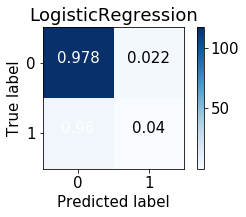

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


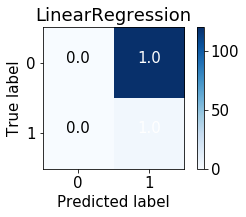

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


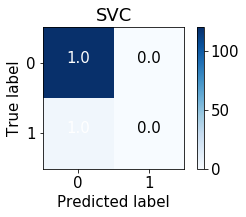

In [16]:
for c in (LogisticRegression, LinearRegression, SVC):
    cls = c()
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test)
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                          title=c.__name__)
    plt.savefig("static_" + c.__name__ + ".png")
    plt.show()
    #print(cnf_matrix)

## CCPEV

Normalized confusion matrix
[[0.98615917 0.01384083]
 [1.         0.        ]]


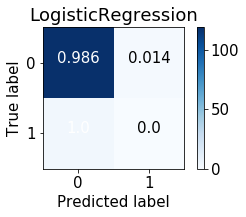

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


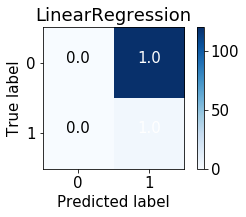

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


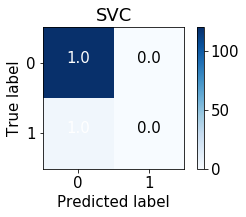

In [17]:
for c in (LogisticRegression, LinearRegression, SVC):
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls = c()
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test)
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int)))
    #print(confusion_matrix(y_test, y_predict.astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                              title=c.__name__)
    plt.savefig("ccpev_" + c.__name__ + ".png")
    plt.show()
    #print(cnf_matrix)

# SPAM

Normalized confusion matrix
[[0.99861304 0.00138696]
 [1.         0.        ]]


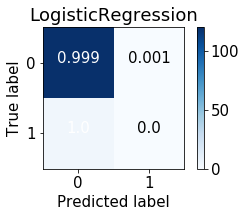

[[120.           0.16666667]
 [  3.83333333   0.        ]]
Normalized confusion matrix
[[0.99791377 0.00208623]
 [1.         0.        ]]


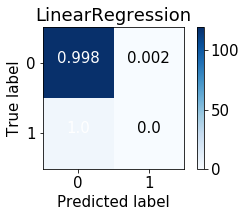

[[119.58333333   0.25      ]
 [  4.16666667   0.        ]]
Normalized confusion matrix
[[0.99790649 0.00209351]
 [1.         0.        ]]


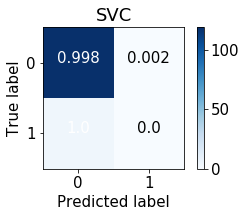

[[119.16666667   0.25      ]
 [  4.58333333   0.        ]]


In [18]:
for c in (LogisticRegression, LinearRegression, SVC):
    cls = LinearRegression(n_jobs=-1)
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test).astype(int)
        #print(y_predict)
   
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int))) # .astype(int)
    #print(confusion_matrix(y_test, y_predict.astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                              title=c.__name__)
    plt.savefig("spam" + c.__name__ + ".png")
    plt.show()
    print(cnf_matrix)